In [1]:
# Create the TFRecord dataset. 
import tensorflow as tf
import pathlib
import PIL
import numpy as np


In [2]:
from collections import namedtuple
ImgShape = namedtuple('ImageShape', 'height width channels')
INPUT_SHAPE = ImgShape(height=240, width=320, channels=3)
dataset = 'crowdhuman'

def _example_to_tensors(example, input_shape: ImgShape):
    example = tf.io.parse_example(
        example[tf.newaxis], {
            'image/encoded': tf.io.FixedLenFeature(shape=(), dtype=tf.string),
            'image/num_people': tf.io.FixedLenFeature(shape=(), dtype=tf.int64)
        })
    img_tensor =  tf.io.decode_jpeg(example['image/encoded'][0])
    img_tensor = tf.image.resize(img_tensor, (input_shape.height, input_shape.width))
    num_tensor = example['image/num_people'][0]
    return img_tensor, num_tensor

def load_dataset(dataset_name: str, input_shape: ImgShape, split="train"):
    """
    split: 'train', 'val', or 'testdev'
    """
    datadir = pathlib.Path('data/regression_tfrecord') / dataset_name
    filenames = [str(p) for p in datadir.glob(f"coco_{split}.record*")]
    tfrecords = tf.data.TFRecordDataset(filenames)
    def _map_fn(example):
        return _example_to_tensors(example, input_shape)
    dataset = tfrecords.map(_map_fn)
    return dataset

train_dataset = load_dataset(dataset, INPUT_SHAPE, split="train")
val_dataset = load_dataset(dataset, INPUT_SHAPE, split="val")
for x, y in train_dataset.take(1):
    print(x, y)

tf.Tensor(
[[[241.36667  241.36667  240.      ]
  [239.6      240.93333  238.26668 ]
  [241.41667  242.75     242.08333 ]
  ...
  [ 25.083334  39.5       54.166668]
  [ 41.867188  69.41748   56.63314 ]
  [ 50.853188  69.634766  58.051105]]

 [[234.95     232.95     233.95    ]
  [236.       236.       238.      ]
  [242.       242.       242.      ]
  ...
  [ 30.        29.75      32.75    ]
  [ 22.94873   18.698242  22.398438]
  [ 38.80078   35.950195  42.70117 ]]

 [[229.88333  229.88333  229.88333 ]
  [230.86667  228.86667  231.86667 ]
  [231.75     229.75     232.75    ]
  ...
  [ 59.249992  55.249992  44.33333 ]
  [ 64.26759   38.066425  43.60093 ]
  [ 73.38576   43.251648  61.120136]]

 ...

 [[ 23.083332  29.749992  21.866663]
  [ 29.249804  30.683172  25.683172]
  [ 33.500183  35.250183  30.250183]
  ...
  [106.58298  102.58298   90.58298 ]
  [103.68367   99.68367   87.68367 ]
  [ 95.68336   91.73316   79.58375 ]]

 [[ 36.749786  38.699783  27.849785]
  [ 24.449919  25.449797  

In [3]:
def dw_conv_stride2_bn_relu(base_filters, level):
    num_filters = base_filters * 2 ** level
    return tf.keras.Sequential([
        # depthwise-separable convolution
        tf.keras.layers.DepthwiseConv2D(kernel_size=3, strides=2, padding='same'),
        # pointwise convolution for feature aggregation
        tf.keras.layers.Conv2D(filters=num_filters, kernel_size=1, strides=1, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU()  
    ])

def build_backbone():
    """
    Construct a backbone of Conv2d-Batchnorm-Relu blocks. 
    """
    return tf.keras.Sequential([dw_conv_stride2_bn_relu(8, level=i) for i in range(5)])

backbone = build_backbone()
backbone.build((1, *INPUT_SHAPE))
backbone.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (1, 120, 160, 8)          94        
_________________________________________________________________
sequential_1 (Sequential)    (1, 60, 80, 16)           288       
_________________________________________________________________
sequential_2 (Sequential)    (1, 30, 40, 32)           832       
_________________________________________________________________
sequential_3 (Sequential)    (1, 15, 20, 64)           2688      
_________________________________________________________________
sequential_4 (Sequential)    (1, 8, 10, 128)           9472      
Total params: 13,374
Trainable params: 12,878
Non-trainable params: 496
_________________________________________________________________


In [4]:
def build_model(input_shape: ImgShape):
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    ])
    backbone = build_backbone()
    preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
    regressor = tf.keras.Sequential(
        [tf.keras.layers.GlobalAveragePooling2D(),
         tf.keras.layers.Flatten(),
         tf.keras.layers.Dense(1, activation=None)]
    )

    inputs = tf.keras.Input(input_shape)
    x = inputs
    x = data_augmentation(x)
    x = preprocess_input(x)
    x = backbone(x)
    outputs = regressor(x)
    model = tf.keras.Model(inputs, outputs)
    return model

model = build_model(INPUT_SHAPE)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 240, 320, 3)]     0         
_________________________________________________________________
sequential_6 (Sequential)    (None, 240, 320, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 240, 320, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 240, 320, 3)       0         
_________________________________________________________________
sequential_12 (Sequential)   (None, 8, 10, 128)        13374     
_________________________________________________________________
sequential_13 (Sequential)   (None, 1)                 129       
Total params: 13,503
Trainable params: 13,007
Non-trainable params: 496
________________________________________________

In [5]:
# Test deployment

model.save(f'exported_models/small_backbone_experimental/saved_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: exported_models/small_backbone_experimental/saved_model/assets


In [9]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    1e-3,
    decay_steps=150,
    decay_rate=0.96,
    staircase=True)


model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule),
              loss=tf.keras.losses.Huber(1.0),
              metrics=[tf.keras.losses.MeanAbsoluteError()])

In [10]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('/home/dtch009/tf-detect/model.ckpt', save_weights_only=True, monitor='val_loss', save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)
]

history = model.fit(train_dataset.batch(100), validation_data = val_dataset.batch(100), epochs=200, callbacks=callbacks, verbose=2)

Epoch 1/200


KeyboardInterrupt: 

In [80]:
model.evaluate(tensor_dataset.batch(100))

      8/Unknown - 11s 1s/step - loss: 9.3330 - mean_absolute_error: 9.8140

KeyboardInterrupt: 

In [29]:
for img, num in tensor_dataset:
    inp = img[tf.newaxis, :,:,:]
    print(model(inp, training=True), model(inp, training=False), num)

tf.Tensor([[13.262511]], shape=(1, 1), dtype=float32) tf.Tensor([[1.5166229]], shape=(1, 1), dtype=float32) tf.Tensor(38, shape=(), dtype=int64)
tf.Tensor([[13.169869]], shape=(1, 1), dtype=float32) tf.Tensor([[1.5368285]], shape=(1, 1), dtype=float32) tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor([[13.257371]], shape=(1, 1), dtype=float32) tf.Tensor([[1.5584854]], shape=(1, 1), dtype=float32) tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor([[13.316663]], shape=(1, 1), dtype=float32) tf.Tensor([[1.5794876]], shape=(1, 1), dtype=float32) tf.Tensor(21, shape=(), dtype=int64)
tf.Tensor([[13.1883135]], shape=(1, 1), dtype=float32) tf.Tensor([[1.5994073]], shape=(1, 1), dtype=float32) tf.Tensor(148, shape=(), dtype=int64)
tf.Tensor([[13.234703]], shape=(1, 1), dtype=float32) tf.Tensor([[1.620273]], shape=(1, 1), dtype=float32) tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor([[13.235745]], shape=(1, 1), dtype=float32) tf.Tensor([[1.640562]], shape=(1, 1), dtype=float32) tf.Tensor(5, shape=(), dt

tf.Tensor([[13.247187]], shape=(1, 1), dtype=float32) tf.Tensor([[2.655059]], shape=(1, 1), dtype=float32) tf.Tensor(15, shape=(), dtype=int64)
tf.Tensor([[13.229697]], shape=(1, 1), dtype=float32) tf.Tensor([[2.6731806]], shape=(1, 1), dtype=float32) tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor([[13.142374]], shape=(1, 1), dtype=float32) tf.Tensor([[2.6903682]], shape=(1, 1), dtype=float32) tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor([[13.235737]], shape=(1, 1), dtype=float32) tf.Tensor([[2.7076542]], shape=(1, 1), dtype=float32) tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor([[13.07303]], shape=(1, 1), dtype=float32) tf.Tensor([[2.725338]], shape=(1, 1), dtype=float32) tf.Tensor(20, shape=(), dtype=int64)
tf.Tensor([[13.217819]], shape=(1, 1), dtype=float32) tf.Tensor([[2.742695]], shape=(1, 1), dtype=float32) tf.Tensor(49, shape=(), dtype=int64)
tf.Tensor([[13.222395]], shape=(1, 1), dtype=float32) tf.Tensor([[2.7592535]], shape=(1, 1), dtype=float32) tf.Tensor(84, shape=(), dtype

tf.Tensor(22, shape=(), dtype=int64)
tf.Tensor(32, shape=(), dtype=int64)
tf.Tensor(13, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)


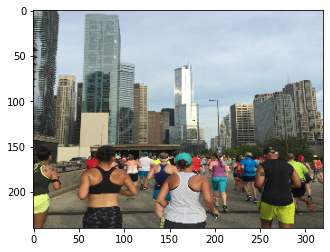

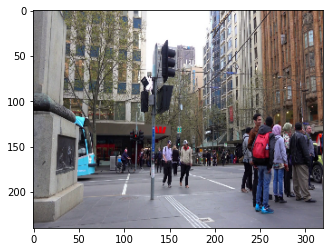

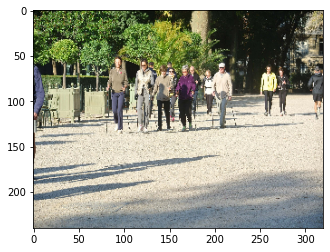

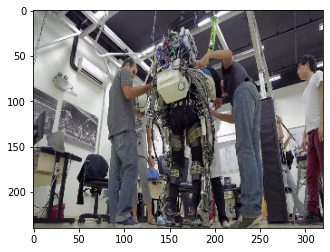

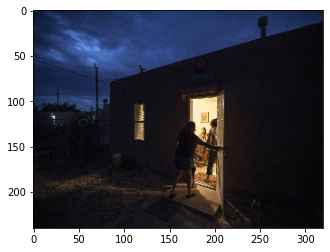

In [31]:
import pathlib
import matplotlib.pyplot as plt
    
dataset = load_dataset('crowdhuman', INPUT_SHAPE, split="train")
for img, num_tensor in dataset.shuffle(128).take(5):
    plt.figure()
    plt.imshow(img / 255.0)
    print(num_tensor)